# Face detection using haarcascade from opencv

In [36]:
#Requierd Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import shutil
import pywt
from math import gamma
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Data Visualization

In [37]:
#Loading Sample Image from Data File of HAppy person
path_happy = "./data/HappyPearson/3 Things Happy People Have - All Pro Dad.jpg"
img_happy = cv2.imread(path_happy)

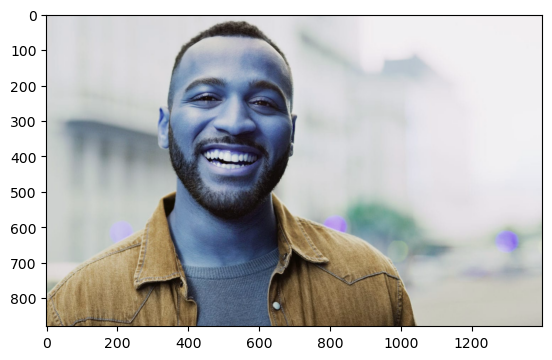

In [38]:
plt.imshow(img_happy)

In [39]:
img_happy.shape

(880, 1400, 3)

In [40]:
#Loading Sample Image from Data File of HAppy person
path_sad = "./data/SadPearson/1_013_665 Sad Face Images_ Stock Photos.jpg"
img_sad = cv2.imread(path_sad)

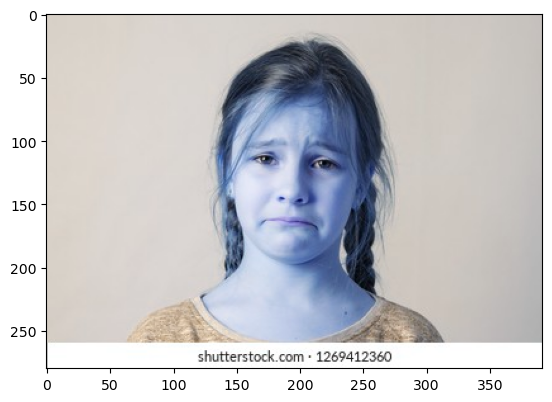

In [41]:
plt.imshow(img_sad)

In [42]:
#Converting Image to Gray scale
gray_img = cv2.cvtColor(img_happy, cv2.COLOR_BGR2GRAY)

In [43]:
gray_img.shape

(880, 1400)

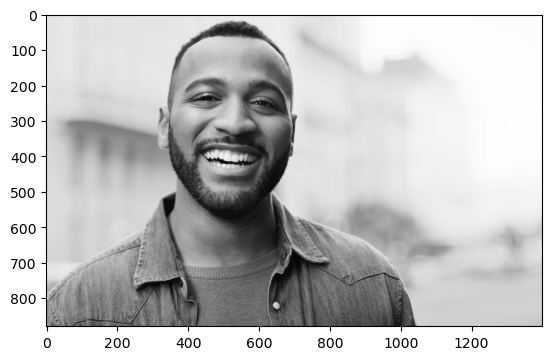

In [44]:
plt.imshow(gray_img,cmap='gray')

In [45]:
#Path to cascade classifier
face_cascade = cv2.CascadeClassifier('./opncv/haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier('./opncv/haarcascade_eye.xml')

In [46]:
#Detecting Face using face cascade
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
faces

array([[325,  79, 418, 418]], dtype=int32)

In [47]:
#Face coordinates
(x,y,w,h) = faces[0]
x,y,w,h

(325, 79, 418, 418)

In [48]:
#adding rectangle around the face in the image
face_img = cv2.rectangle(img_happy,(x,y),(x+w,y+h),(255,0,0),2)

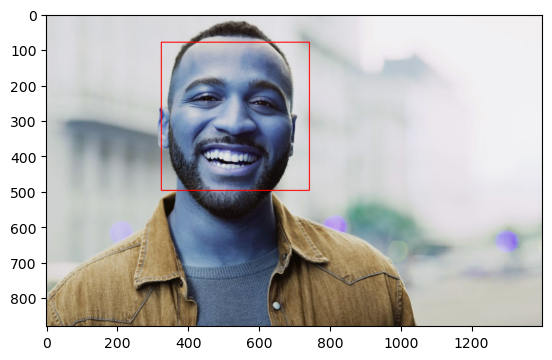

In [49]:
plt.imshow(face_img)

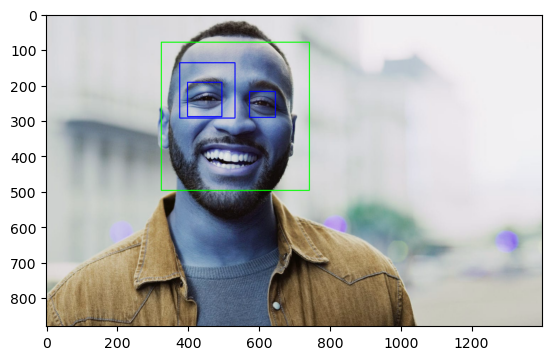

In [50]:
#Detecting and adding rectangles around the eyes, 
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img_happy,(x,y),(x+w,y+h),(0, 255, 0),2)
    roi_gray = gray_img[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eyes_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,0,255),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

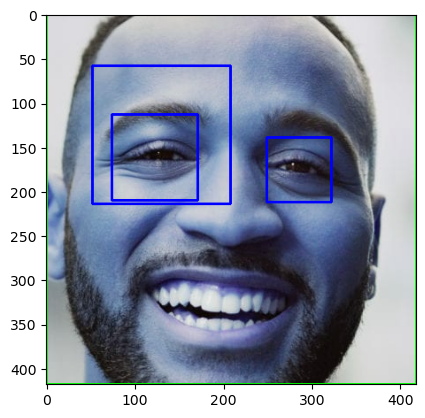

In [51]:
#Croped face
plt.imshow(roi_color, cmap='gray')

In [52]:
#Storing Cropped Image as numpy array
cropped_img = np.array(roi_color)
cropped_img.shape

(418, 418, 3)

# Wavelet tranform

In [53]:
def wavelet2d(image, mode='haar', level=1):
    imageArray = image
    #converting to gray scale
    imageArray = cv2.cvtColor(imageArray, cv2.COLOR_RGB2GRAY)
    
    #convertion values to float
    imageArray = np.float32(imageArray)
    imageArray /= 255
    
    #calculating coefficents
    coefficients = pywt.wavedec2(imageArray, mode,level=level)
    
    #process coefficients
    coefficients_H=list(coefficients)
    coefficients_H[0] *= 0
    
    #recunstructing image
    imageArray_H = pywt.waverec2(coefficients_H,mode)
    imageArray_H *= 255
    imageArray_H= np.uint8(imageArray_H)
    return imageArray_H

/var/folders/yx/sqtjt7tj60zc4gdw10f4yq1c0000gp/T/ipykernel_14467/4156481074.py:20: RuntimeWarning: invalid value encountered in cast
  imageArray_H= np.uint8(imageArray_H)


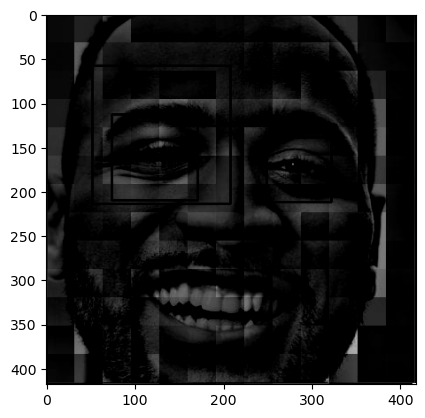

In [54]:
#Wavelet transorming image to extract details on facial feature
har_img = wavelet2d(cropped_img,'db1',5)
plt.imshow(har_img, cmap='gray')

## Requierd Functions

In [55]:
#function purpose to crop an image that contains both face and a eyes
def get_cropped_image_if_eyes(image_path):
    image = cv2.imread(image_path)
    faces = face_cascade.detectMultiScale(image,1.3, 5)
    for (face_x,face_y,face_w,face_h) in faces:
     roi_color = image[face_y:face_y+face_h, face_x:face_x+face_w]
     eyes = eyes_cascade.detectMultiScale(roi_color)
     if len(eyes) > 1:
         return roi_color
     else: return None

In [56]:
cropped_image = get_cropped_image_if_eyes(path_sad)

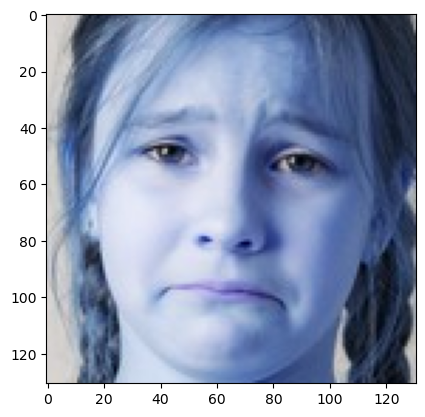

In [57]:
plt.imshow(cropped_image)

In [58]:
#Path To Face's data
path_to_data = "./data"
path_to_cropped_data = "./data/cropped"

In [59]:
image_directories =[]
for entry in os.scandir(path_to_data):
    if entry.is_dir():
         image_directories.append(entry.path)
         

In [60]:
if os.path.exists(path_to_cropped_data):
  shutil.rmtree(path_to_cropped_data) #delete path
os.mkdir(path_to_cropped_data)

In [61]:
cropped_image_directories = []
person_file_names_dictionery = {} #dictonery 

In [62]:
#Gettig name of image directory (Happy Person or Sad Person face directory)
for image_directorie in image_directories:
     count = 1
     person_face = image_directorie.split('/')[-1] #geeting diclrectory name
   
     person_file_names_dictionery[person_face] = []
     
     for entry in os.scandir(image_directorie):
       
         roi_color = get_cropped_image_if_eyes(entry.path)
         if roi_color is not None:
              cropped_folder = path_to_cropped_data+ "/" + person_face
              if not os.path.exists(cropped_folder):
                  os.makedirs(cropped_folder)
                  cropped_image_directories.append(cropped_folder)
                      
              cropped_file_name = person_face  + str(count)+ ".png"
              cropped_file_path = cropped_folder + "/" + cropped_file_name
              cv2.imwrite(cropped_file_path,roi_color)
              person_file_names_dictionery[person_face].append(cropped_file_path)
              count+=1
              

In [63]:
for image_directorie in cropped_image_directories:
    person_face = image_directorie.split('/')[-1]
    file_list = [] 
    for entry in os.scandir(image_directorie):
        file_list.append(entry.path)
    person_file_names_dictionery[person_face] = file_list
person_file_names_dictionery

{'SadPearson': ['./data/cropped/SadPearson/SadPearson65.png',
  './data/cropped/SadPearson/SadPearson59.png',
  './data/cropped/SadPearson/SadPearson58.png',
  './data/cropped/SadPearson/SadPearson64.png',
  './data/cropped/SadPearson/SadPearson66.png',
  './data/cropped/SadPearson/SadPearson63.png',
  './data/cropped/SadPearson/SadPearson62.png',
  './data/cropped/SadPearson/SadPearson48.png',
  './data/cropped/SadPearson/SadPearson60.png',
  './data/cropped/SadPearson/SadPearson61.png',
  './data/cropped/SadPearson/SadPearson49.png',
  './data/cropped/SadPearson/SadPearson1.png',
  './data/cropped/SadPearson/SadPearson12.png',
  './data/cropped/SadPearson/SadPearson13.png',
  './data/cropped/SadPearson/SadPearson2.png',
  './data/cropped/SadPearson/SadPearson11.png',
  './data/cropped/SadPearson/SadPearson39.png',
  './data/cropped/SadPearson/SadPearson38.png',
  './data/cropped/SadPearson/SadPearson10.png',
  './data/cropped/SadPearson/SadPearson3.png',
  './data/cropped/SadPearson/

In [64]:
person_file_names_dictionery.keys()

dict_keys(['SadPearson', 'HappyPearson', 'cropped'])

In [65]:
class_dictionery = {}
count = 0 
for person_face in person_file_names_dictionery.keys():
    class_dictionery[person_face] = count
    count +=1 

In [66]:
class_dictionery

{'SadPearson': 0, 'HappyPearson': 1, 'cropped': 2}

In [67]:
del class_dictionery["cropped"]

In [68]:
class_dictionery

{'SadPearson': 0, 'HappyPearson': 1}

# GridSearchCV with SVM, Random_Forest and Logistic Regression

In [69]:
X= [] #model input
Y = []  #model output

In [70]:
#Staking initial image and wavelet image
for person_face, training_file in person_file_names_dictionery.items():
    for training_image in training_file:
        image = cv2.imread(training_image)
        if image is not None:
         saclled_raw_image = cv2.resize(image,(32,32))
         image_har =wavelet2d(image,'db1',5)
         sacalled_image_har = cv2.resize(image_har,(32,32))
         combined_image = np.vstack((saclled_raw_image.reshape(32*32*3,1),sacalled_image_har.reshape(32*32,1)))
         X.append(combined_image)
         Y.append(class_dictionery[person_face])

/var/folders/yx/sqtjt7tj60zc4gdw10f4yq1c0000gp/T/ipykernel_14467/4156481074.py:20: RuntimeWarning: invalid value encountered in cast
  imageArray_H= np.uint8(imageArray_H)


In [71]:
#reshaping  to (40,4096), and converting to flaot
X = np.array(X).reshape(len(X),4096).astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0)

In [72]:
#Hyper parameter Tuning (GridSearchCV)
#Dictonery to hold model details for parameter tuning

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [73]:
scores = [] #Keep track of thE scores
best_estimators ={} #Store the best estimators

In [74]:
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, Y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

In [75]:
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [76]:
best_estimators['svm'].score(X_test, Y_test)

0.8571428571428571

In [77]:
best_estimators['random_forest'].score(X_test, Y_test)

0.5714285714285714

In [78]:
best_estimators['logistic_regression'].score(X_test, Y_test)

0.75

In [79]:
best_clf = best_estimators['svm']

In [80]:
#Evaluating Model using confusion_matrix
cm = confusion_matrix(Y_test, best_clf.predict(X_test))
cm

array([[15,  1],
       [ 3,  9]])

<Axes: >

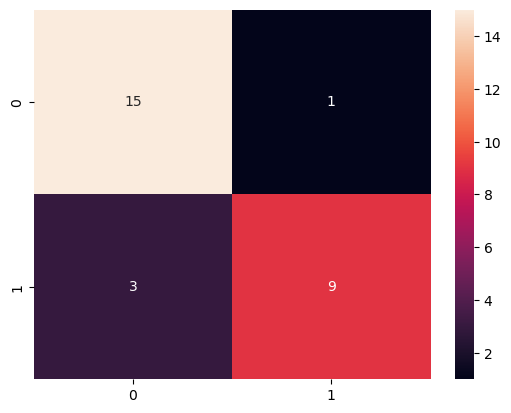

In [81]:
#Ploting Confusion Matrix
sns.heatmap(cm, annot=True)

In [82]:
class_dictionery 

{'SadPearson': 0, 'HappyPearson': 1}

- <font size = 4> Observations: Both SVM and Linear Regression model obtained 

In [83]:
#Saving Model
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [84]:
#Saving Class Dictionary 
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dictionery))